# mDPP

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv, MDPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.models.rl.reinforce.baselines import CriticBaseline, RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.models.rl.reinforce.critic import CriticNetwork

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## mDPP Environment

We declare the environment here. This will automatically download the data 

In [2]:
env = MDPPEnv(reward_type="minmax", max_decaps=20) # TODO: load datasets

td = env.reset(batch_size=[2])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        i: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        keepout: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([2, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=False)


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
bs = 10

td = env.reset(batch_size=[bs])
td_init = td.clone()

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

for i in range(20):
    # pick random action from action_mask
    td = random_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions_ = torch.stack(actions, dim=1)

/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:294: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=c, edgecolor="k", linestyle="-", linewidth=1)


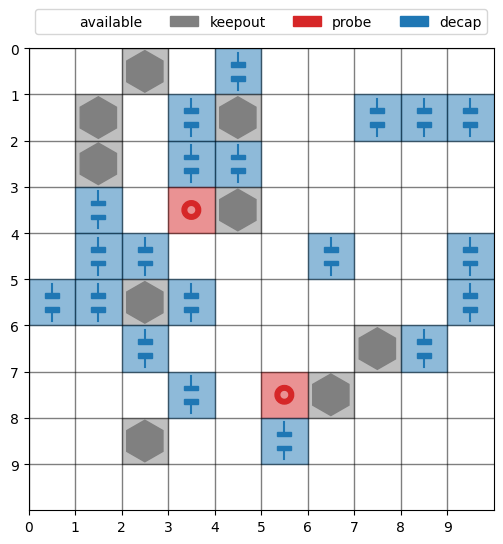

In [4]:
env.render(td[0], actions_[0])

## Attention Model

In [5]:
# Load environment with test data

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=tensordict_collate_fn,
)

policy = AttentionModelPolicy(
    env,
)

# model = torch.compile(model)

td = next(iter(dataloader))
td = env.reset(td)

out = policy(td, decode_type="sampling")

print(out)

{'reward': tensor([ 7.9017, 10.1837,  8.4462, 10.2022,  7.8692,  7.4245,  8.0997, 11.3946,
         8.9455,  9.4270, 10.0083, 10.4873,  7.2043,  9.1343, 10.6067,  9.2242,
        10.4427,  9.0702,  9.1403,  8.2732,  9.2261,  7.3275, 10.2069, 10.3424,
         7.0193, 10.1211,  6.8335, 10.4038,  9.4361, 10.0273,  8.5945,  9.6415,
         9.1208, 10.2919,  8.1304,  9.2707,  9.7710,  9.2523,  9.3130,  8.3743,
         7.5079, 10.3137,  8.2494,  7.8976,  9.0088, 10.1238,  8.3757,  9.4875,
        10.2504,  9.1300,  8.0735,  8.6491,  8.5518,  9.2933,  9.0779,  8.0016,
         8.0825,  8.3825,  8.2909,  7.7137,  6.8955,  9.4254,  7.7671,  9.4296]), 'log_likelihood': tensor([-78.4076, -75.5016, -77.9378, -74.4272, -75.7097, -73.2738, -82.6986,
        -66.3492, -81.3686, -73.0596, -86.5989, -84.0229, -70.9388, -75.3753,
        -66.4025, -87.3464, -85.4361, -87.3629, -83.0605, -70.4687, -71.4244,
        -84.3842, -88.9384, -83.1283, -82.1525, -66.4592, -77.1817, -80.0291,
        -80.4023,

In [6]:
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(
    env,
    policy,
    baseline,
)


td = next(iter(dataloader))

td = env.reset(td)
init_td = td.clone()


# out = model(td, decode_type="sampling")

# print(out)

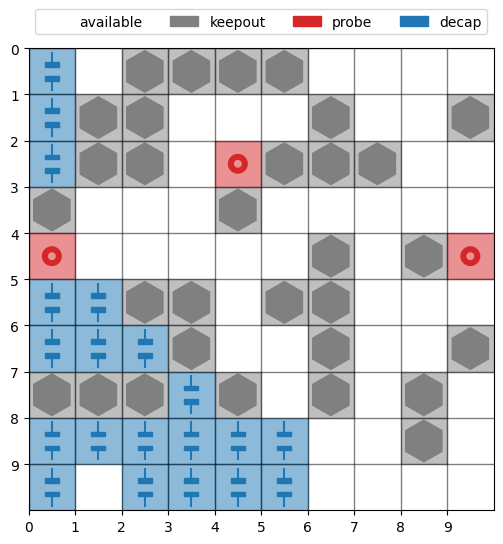

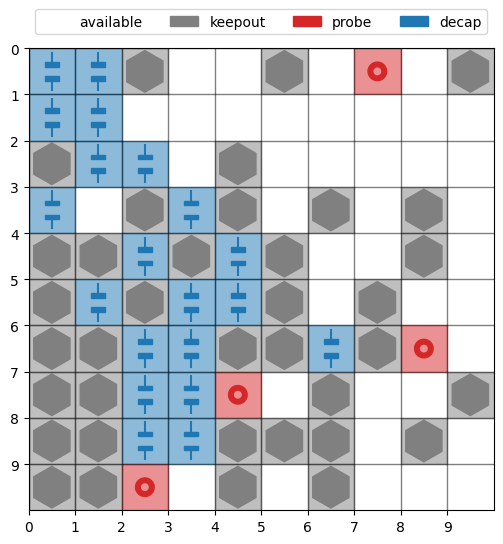

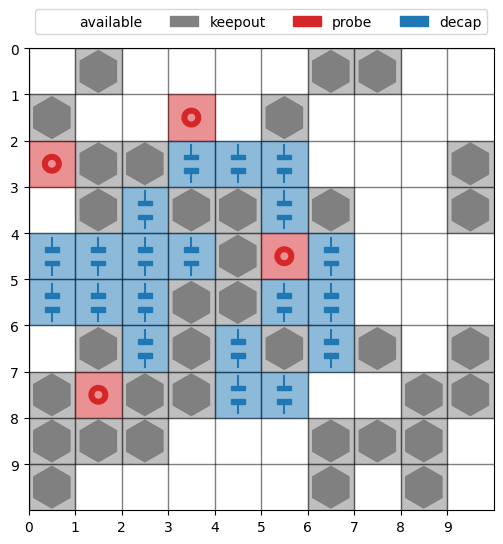

In [7]:
## Plot

probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(init_td[i], decaps[i])


# Main setup

In [8]:
config = DictConfig(
    {"data": {
            "train_size": 1000, # with 1 epochs, this is 1k samples
            "val_size": 100, 
            "test_size": 100,
            "batch_size": 16,
    },
    "optimizer": {
        "lr": 1e-4,
        "weight_decay": 0,
    },
    "num_epochs": 10,
    })

# Recreate model (so CUDA is initialized in the model)

# baseline = ExponentialBaseline()
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(env, baseline=baseline)

lit_module = RL4COLitModule(cfg=config, env=env, model=model)

In [9]:
# Trainer
trainer = L.Trainer(
    max_epochs=config.num_epochs, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    devices=[0], # GPU number, or multiple GPUs [0, 1, 2, ...]
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
No optimizer specified, using default

  | Name  | Type           | Params
-----------------------------------------
0 | env   | MDPPEnv        | 0     
1 | model | AttentionModel | 1.5 M 
-----------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.810     Total estimated model params 

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())
/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Results

In [10]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")
batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(9.5964, device='cuda:0')

/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:294: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=c, edgecolor="k", linestyle="-", linewidth=1)


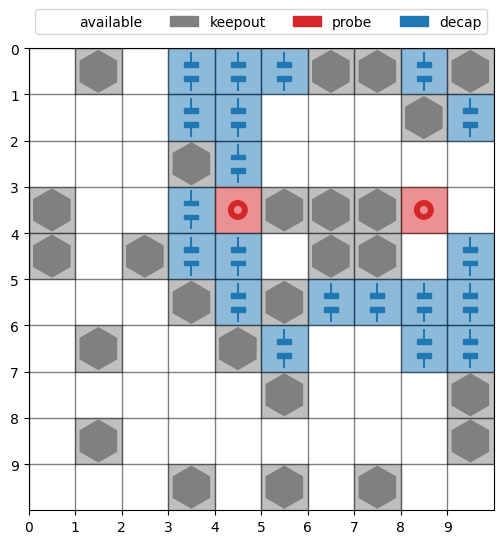

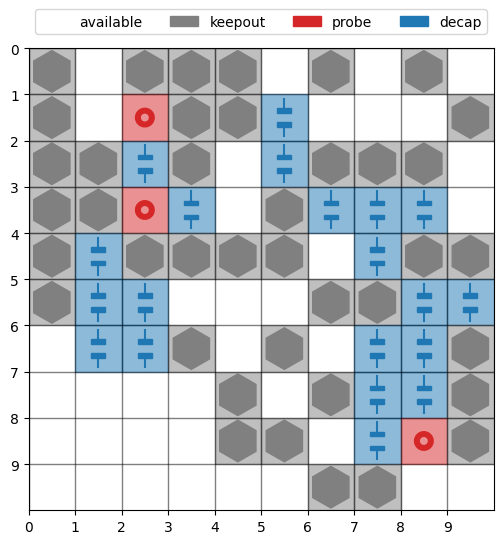

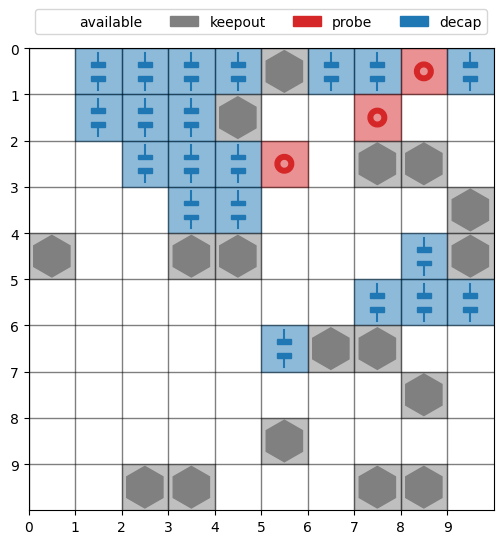

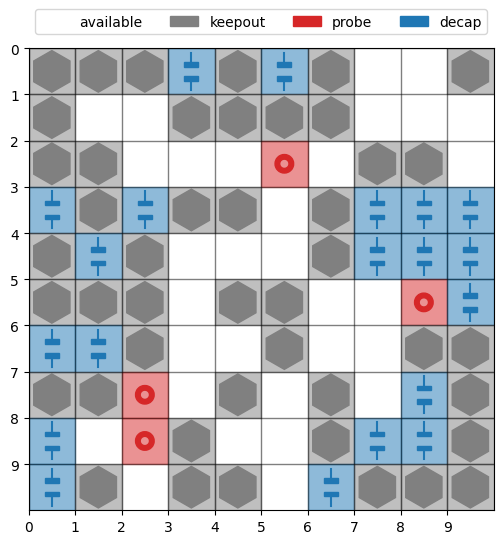

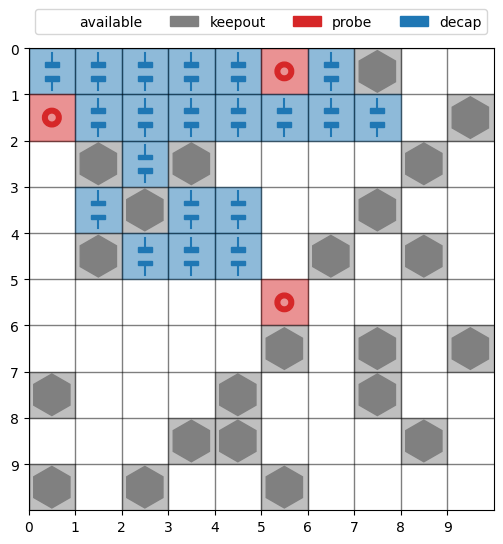

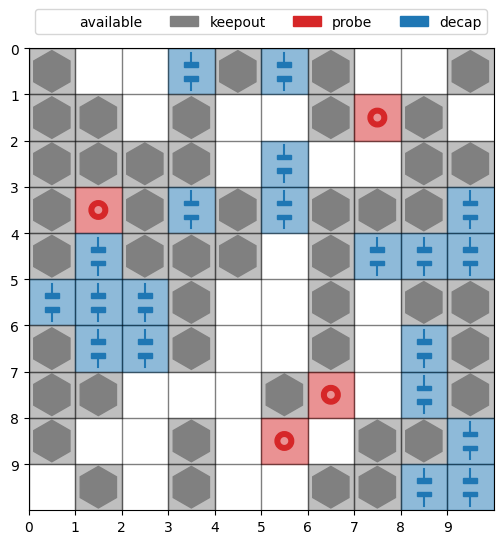

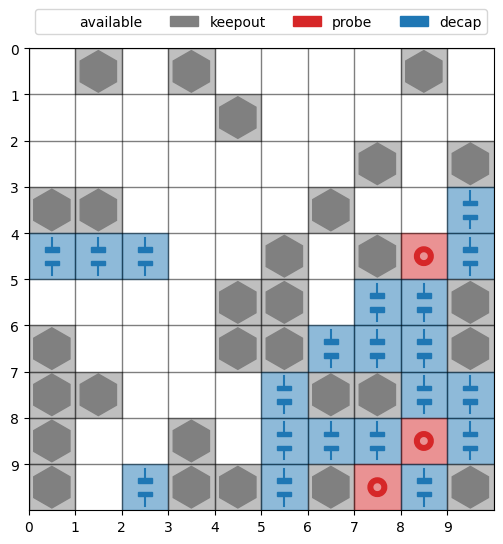

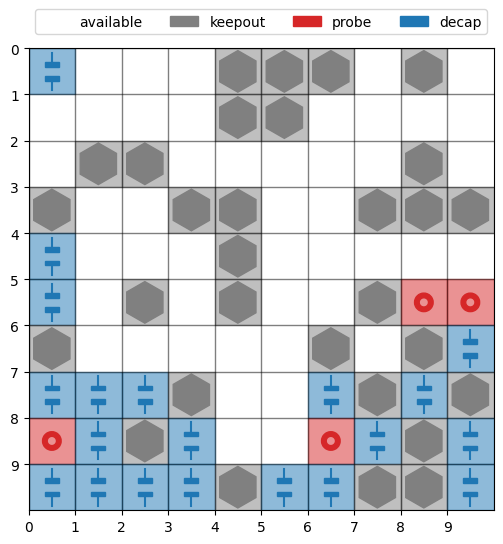

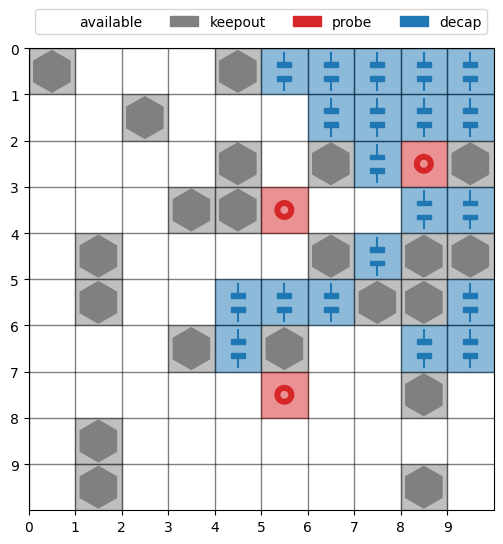

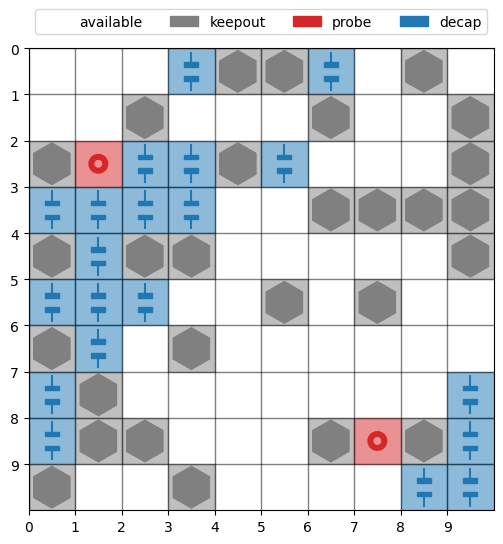

In [11]:
## Plot

init_td = env.reset(batch).to("cuda")
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(10):
    env.render(init_td[i], decaps[i])
